# Optimierungsgrundlagen
In diesem Notebook zeigen wir, wie man einen Workflow zur Bildsegmentierung einrichtet und dessen Parameter mit einer gegebenen spärlichen Annotation optimiert.

Siehe auch:
* [Jaccard-Index](https://en.wikipedia.org/wiki/Jaccard_index)
* [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

In [1]:
from skimage.io import imread
from scipy.optimize import minimize
import numpy as np
import pyclesperanto_prototype as cle

Wir beginnen mit dem Laden eines Beispielbildes und einer manuellen Annotation. Es müssen nicht alle Objekte annotiert sein (spärliche Annotation).

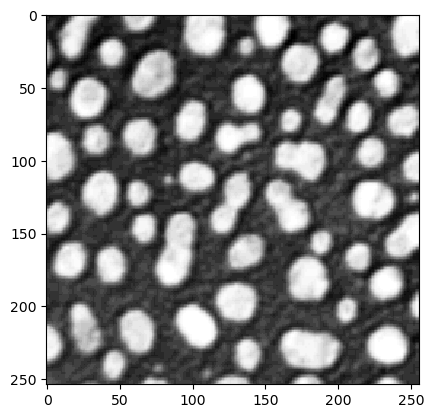

In [2]:
blobs = imread('../../data/blobs.tif')

cle.imshow(blobs)

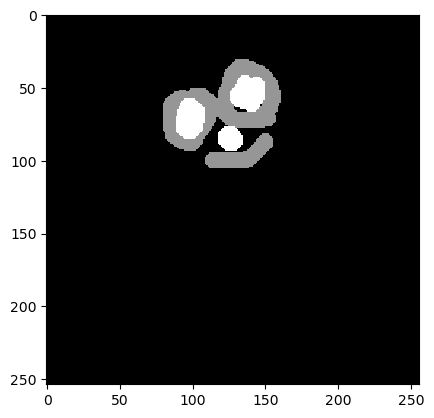

In [3]:
annotation = imread('../../data/blobs_annotated.tif')

cle.imshow(annotation)

Als Nächstes definieren wir einen Bildverarbeitungs-Workflow, der zu einem Binärbild führt.

In [4]:
def workflow(image, sigma, threshold):
    blurred = cle.gaussian_blur(image, sigma_x=sigma, sigma_y=sigma)
    binary = cle.greater_constant(blurred, constant=threshold)
    return binary

Wir testen diesen Workflow auch mit einigen zufälligen `sigma` und `threshold` Werten.

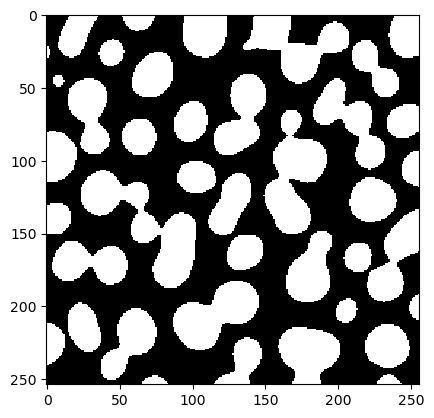

In [5]:
test = workflow(blobs, 5, 100)
cle.imshow(test)

Unsere [Fitnessfunktion](https://en.wikipedia.org/wiki/Fitness_function) nimmt zwei Parameter: Ein gegebenes Segmentierungsergebnis (test) und eine Referenzannotation. Sie bestimmt dann, wie gut die Segmentierung ist, z.B. unter Verwendung des Jaccard-Index.

In [6]:
binary_and = cle.binary_and

def fitness(test, reference):
    """
    Bestimmt, wie korrekt eine gegebene Testsegmentierung ist. 
    Als Metrik verwenden wir den Jaccard-Index.
    Annahme: test ist ein Binärbild (0=Falsch und 1=Wahr) und 
    reference ist ein Bild mit 0=unbekannt, 1=Falsch, 2=Wahr.
    """
    negative_reference = reference == 1
    positive_reference = reference == 2
    negative_test = test == 0
    positive_test = test == 1
    
    # true positive: test = 1, ref = 2
    tp = binary_and(positive_reference, positive_test).sum()
    
    # true negative: 
    tn = binary_and(negative_reference, negative_test).sum()
    
    # false positive
    fp = binary_and(negative_reference, positive_test).sum()

    # false negative
    fn = binary_and(positive_reference, negative_test).sum()
    
    # return Jaccard Index
    return tp / (tp + fn + fp)

fitness(test, annotation)

0.74251497

Wir sollten diese Funktion auch für eine Reihe von Parametern testen.

In [7]:
sigma = 5
for threshold in range(70, 180, 10):
    test = workflow(blobs, sigma, threshold)
    print(threshold, fitness(test, annotation))

70 0.49048626
80 0.5843038
90 0.67019403
100 0.74251497
110 0.8183873
120 0.8378158
130 0.79089373
140 0.7024014
150 0.60603446
160 0.49827588
170 0.3974138


Als Nächstes definieren wir eine `fun`ktion, die nur numerische Parameter enthält, die optimiert werden sollen.

In [8]:
def fun(x):
    # aktuelle Parametereinstellung anwenden
    test = workflow(blobs, x[0], x[1])
    # da wir minimieren, multiplizieren wir die Fitness mit -1
    return -fitness(test, annotation)

Bevor wir mit der Optimierung beginnen, besteht der letzte Schritt darin, den Startpunkt `x0` für die Optimierung und das Abbruchkriterium `atol`, den absoluten Toleranzwert, zu konfigurieren.

In [9]:
# Startpunkt im Parameterraum
x0 = np.array([5, 100])

# Optimierung durchführen
result = minimize(fun, x0, method='nelder-mead', options={'xatol': 1e-3})
result

 final_simplex: (array([[  3.89501953, 121.94091797],
       [  3.89498663, 121.9409585 ],
       [  3.89500463, 121.9403702 ]]), array([-0.85761315, -0.85761315, -0.85761315]))
           fun: -0.8576131463050842
       message: 'Optimization terminated successfully.'
          nfev: 65
           nit: 22
        status: 0
       success: True
             x: array([  3.89501953, 121.94091797])

Aus diesem `result`-Objekt können wir den Parametersatz auslesen, der als optimal ermittelt wurde, und ein Binärbild erzeugen.

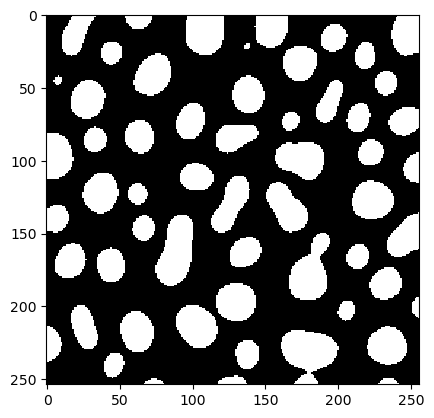

In [10]:
x = result['x']
best_binary = workflow(blobs, x[0], x[1])
cle.imshow(best_binary)

## Eine Anmerkung zur Konvergenz

Optimierungsalgorithmen finden möglicherweise nicht immer das globale Optimum. Der Erfolg hängt vom Startpunkt der Optimierung, von der Form des Parameterraums und dem gewählten Algorithmus ab. Im folgenden Beispiel zeigen wir, wie eine fehlgeschlagene Optimierung aussehen kann, wenn der Startpunkt schlecht gewählt wurde.

In [11]:
# Startpunkt im Parameterraum
x0 = np.array([0, 60])

# Optimierung durchführen
result = minimize(fun, x0, method='nelder-mead', options={'xatol': 1e-3})
result

 final_simplex: (array([[0.00000000e+00, 6.00000000e+01],
       [6.10351563e-08, 6.00000000e+01],
       [0.00000000e+00, 6.00007324e+01]]), array([-0.63195992, -0.63195992, -0.63195992]))
           fun: -0.6319599151611328
       message: 'Optimization terminated successfully.'
          nfev: 51
           nit: 13
        status: 0
       success: True
             x: array([ 0., 60.])

## Fehlerbehebung: Erkundung des Parameterraums
In diesem Fall unterscheidet sich der resultierende Parametersatz nicht vom Startpunkt. Falls sich die Fitness um den Startpunkt herum nicht ändert, weiß der Optimierungsalgorithmus nicht, wie er das Ergebnis verbessern soll. Die Visualisierung der Werte um den Startpunkt herum kann helfen.

In [12]:
sigma = 0
for threshold in range(57, 63):
    test = workflow(blobs, sigma, threshold)
    print(threshold, fitness(test, annotation))

57 0.6319599
58 0.6319599
59 0.6319599
60 0.6319599
61 0.6319599
62 0.6319599


In [13]:
threshold = 60
for sigma in np.arange(0, 0.5, 0.1):
    test = workflow(blobs, sigma, threshold)
    print(sigma, fitness(test, annotation))

0.0 0.6319599
0.1 0.6319599
0.2 0.6319599
0.30000000000000004 0.6319599
0.4 0.6319599


Daher ist es sinnvoll, vor der automatischen Optimierung eine manuelle Erkundung des Parameterraums durchzuführen.